In [2]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
for dirname, _, filenames in os.walk('/home/shashankvenkat/DLP/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/shashankvenkat/DLP/input/cataractdataset/README.md
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_001.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_002.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_003.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_004.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_005.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_006.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_007.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_008.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_009.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_010.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_011.png
/home/shashankvenkat/DLP/input/cataractdataset/dataset/1_normal/NL_012.png
/home/shashankvenkat/DLP/input/cataractdata

In [3]:
df = pd.read_csv("/home/shashankvenkat/DLP/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


In [11]:
print(len(cataract),len(normal))

594 500


In [15]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/home/shashankvenkat/DLP/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [16]:
dataset = create_dataset(cataract,1)

 21%|██        | 126/594 [00:00<00:02, 215.68it/s][ WARN:0@65.919] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/shashankvenkat/DLP/input/ocular-disease-recognition-odir5k/preprocessed_images/2231_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@65.958] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/shashankvenkat/DLP/input/ocular-disease-recognition-odir5k/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@65.971] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/shashankvenkat/DLP/input/ocular-disease-recognition-odir5k/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
100%|██████████| 594/594 [00:02<00:00, 217.00it/s]


In [17]:
len(dataset)

588

In [18]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 206.83it/s]


In [19]:
len(dataset)

1088

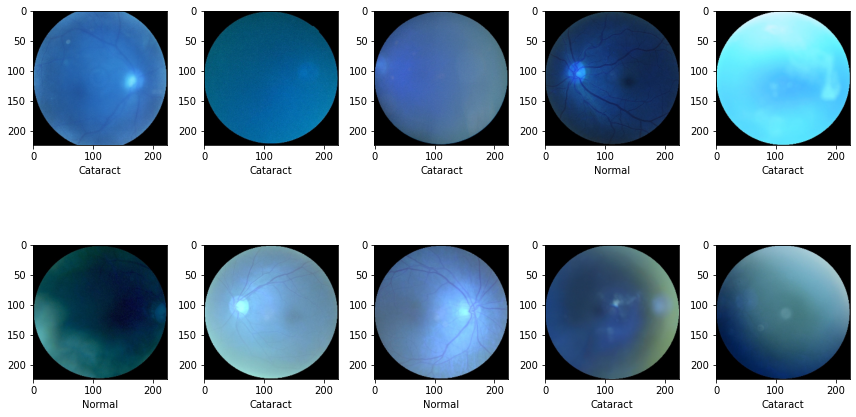

In [20]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [21]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [23]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

2022-07-24 13:38:35.203480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 13:38:35.203807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64/python3.10/site-packages/cv2/../../lib64:
2022-07-24 13:38:35.203910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64/python3.10/site-packages/cv2/../../lib64:
2022-07-24 13:38:35.203988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11

In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [27]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [29]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])#32

Epoch 1/15


2022-07-24 13:39:09.233260: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 130959360 exceeds 10% of free system memory.
2022-07-24 13:39:10.253379: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2022-07-24 13:39:10.262791: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-24 13:39:10.451148: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-24 13:39:11.168332: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.


28/28 [==============================] - 204s 7s/step - loss: 1.8723 - accuracy: 0.8724 - val_loss: 1.8884 - val_accuracy: 0.8991
Epoch 2/15
28/28 [==============================] - 195s 7s/step - loss: 0.7523 - accuracy: 0.9494 - val_loss: 0.9779 - val_accuracy: 0.9541
Epoch 3/15
28/28 [==============================] - 191s 7s/step - loss: 0.0770 - accuracy: 0.9816 - val_loss: 0.5401 - val_accuracy: 0.9725
Epoch 4/15
28/28 [==============================] - 193s 7s/step - loss: 0.1177 - accuracy: 0.9793 - val_loss: 0.7976 - val_accuracy: 0.9679
Epoch 5/15
28/28 [==============================] - 194s 7s/step - loss: 0.0220 - accuracy: 0.9966 - val_loss: 0.6144 - val_accuracy: 0.9679
Epoch 6/15
28/28 [==============================] - 196s 7s/step - loss: 6.2774e-04 - accuracy: 1.0000 - val_loss: 0.5198 - val_accuracy: 0.9771
Epoch 7/15
28/28 [==============================] - 193s 7s/step - loss: 6.2141e-05 - accuracy: 1.0000 - val_loss: 0.5465 - val_accuracy: 0.9725
Epoch 8/15
28/28

In [34]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 47s 7s/step - loss: 0.2437 - accuracy: 0.9771
loss: 0.24374687671661377
Accuracy: 0.9770641922950745


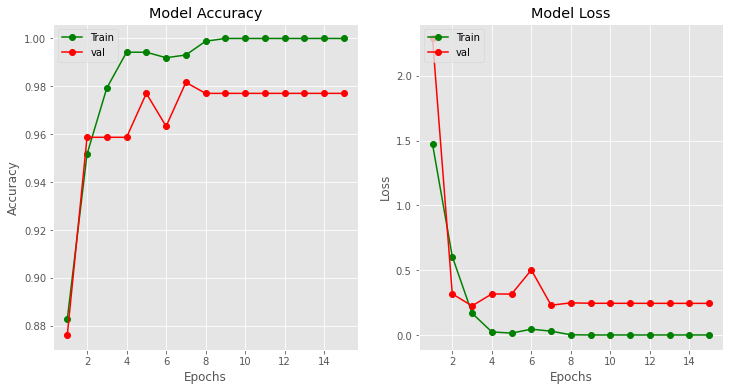

In [35]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(x_test, verbose=0),axis=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(yhat_classes,y_test)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
'''confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)'''

NameError: name 'model' is not defined

In [36]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

NameError: name 'y_pred' is not defined

<Figure size 864x504 with 0 Axes>